In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import torch
import torch.nn as nn
torch.manual_seed(0)
device = torch.device("cuda")

import torch.optim as optim
import torch.nn.functional as F
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

In [4]:
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as T

from PIL import Image
from torch.utils.data import DataLoader,sampler,Dataset

import scipy.io

label_mat=scipy.io.loadmat('./data/hw6_data.mat')
label_train=label_mat['trLb']
label_val=label_mat['valLb']

class ActionDataset(Dataset):
    def __init__(self,  root_dir,labels=[], transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.length=len(os.listdir(self.root_dir))
        self.labels=labels
        
    def __len__(self):
        return self.length*3

    def __getitem__(self, idx):
        
        folder=int(idx/3)+1
        imidx=idx%3+1
        folder=format(folder,'05d')
        imgname=str(imidx)+'.jpg'
        img_path = os.path.join(self.root_dir,
                                folder,imgname)
        image = Image.open(img_path)
        if len(self.labels)!=0:
            Label=self.labels[int(idx/3)][0]-1
        if self.transform:
            image = self.transform(image)
        if len(self.labels)!=0:
            sample={'image':image,'img_path':img_path,'Label':Label}
        else:
            sample={'image':image,'img_path':img_path}
        return sample

In [5]:
train_tf = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

import torchvision.models as models
resnet18 = models.resnet18(pretrained=True).cuda()
resnet18.eval()

image_dataset_train=ActionDataset(root_dir='./data/trainClips/',
                                  labels=label_train,transform=train_tf)
image_dataloader_train = DataLoader(image_dataset_train, batch_size=32, 
                                    shuffle=True, num_workers=4)

image_dataset_val = ActionDataset(root_dir='./data/valClips/',
                                labels=label_val,transform=train_tf)
image_dataloader_val = DataLoader(image_dataset_val, batch_size=32, 
                                  shuffle=False, num_workers=4)

image_dataset_test=ActionDataset(root_dir='./data/testClips/',
                                 labels=[],transform=train_tf)
image_dataloader_test = DataLoader(image_dataset_test, batch_size=32, 
                                   shuffle=False, num_workers=4)

In [6]:
mlp = nn.Sequential(
    nn.ReLU(inplace=True),
    nn.Linear(1000, 10),
)

model = mlp.to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss().to(device)

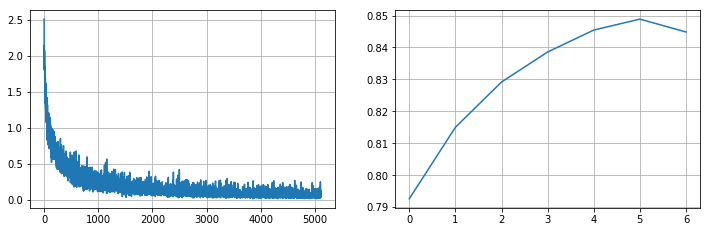

Process Process-59:
Process Process-60:
Process Process-57:
Process Process-58:
Traceback (most recent call last):
  File "/home/hlh0923/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/hlh0923/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/hlh0923/miniconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 106, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/hlh0923/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/hlh0923/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/hlh0923/miniconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 184, in default_

KeyboardInterrupt: 

In [7]:
from torch.autograd import Variable

num_epochs = 50
train_losses = []
valid_accs = []
valid_losses = []

for epoch in range(num_epochs):
    for t, sample in enumerate(image_dataloader_train):
        model.train()
        x_var = Variable(sample['image'].cuda())
        y_var = Variable(sample['Label'].cuda().long())

        x_var = resnet18(x_var)
        scores = model(x_var)
        loss = loss_fn(scores, y_var)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
    model.eval()
    num_correct = 0
    num_samples = 0
    for t, sample in enumerate(image_dataloader_val):
        x_var = Variable(sample['image'].cuda())
        y_var = Variable(sample['Label'].cuda().long())
        
        x_var = resnet18(x_var)
        scores = model(x_var)

        _, preds = scores.data.cpu().max(1)
        y_var=y_var.cpu()
        num_correct += (preds.numpy() == y_var.numpy()).sum()
        num_samples += preds.size(0)

    acc = float(num_correct) / num_samples   
    valid_accs.append(acc)

    clear_output(True)
    plt.figure(figsize=(12,8))
    plt.subplot(221)
    plt.plot(train_losses)
    plt.grid(True)
    plt.subplot(222)
    plt.plot(valid_accs)
    plt.grid(True)
    plt.show()

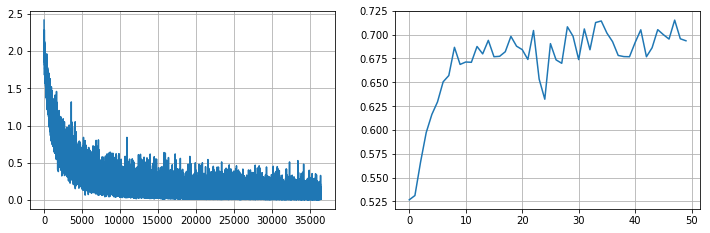

In [11]:
clear_output(True)
plt.figure(figsize=(12,8))
plt.subplot(221)
plt.plot(train_losses)
plt.grid(True)
plt.subplot(222)
plt.plot(valid_accs)
plt.grid(True)
plt.show()

In [48]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.relu = nn.ReLU()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        y = self.bn3(self.conv3(x))
        z = self.relu(self.bn1(self.conv1(x)))
        z = self.bn2(self.conv2(z))
        return y+z

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, padding=1)
        self.dropout = nn.Dropout()
        
#         self.conv1 = nn.Conv2d(3, 8, kernel_size=3, bias=False)
#         self.bn1 = nn.BatchNorm2d(8)
#         self.conv2 = nn.Conv2d(8, 16, kernel_size=3, bias=False)
#         self.bn2 = nn.BatchNorm2d(16)
#         self.conv3 = nn.Conv2d(16, 32, kernel_size=3, bias=False)
#         self.bn3 = nn.BatchNorm2d(32)
#         self.conv4 = nn.Conv2d(32, 64, kernel_size=3, bias=False)
#         self.bn4 = nn.BatchNorm2d(64)
        
        self.res1 = ResidualBlock(3,8)
        self.res2 = ResidualBlock(8,16)
        self.res3 = ResidualBlock(16,32)
        self.res4 = ResidualBlock(32,64)
        self.linear = nn.Linear(1600, 10)
        
    def forward(self, x):
        x = self.pool(self.res1(x))
        x = self.pool(self.res2(x))
        x = self.pool(self.res3(x))
        x = self.pool(self.res4(x))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x
    
model = Model().to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4)
loss_fn = nn.MultiMarginLoss().to(device)

In [49]:
# class Flatten(nn.Module):
#     def forward(self, x):
#         N, C, H, W = x.size() # read in N, C, H, W
#         return x.view(N, -1)

# fixed_model_base = nn.Sequential( 
#     # Layer 1
#     nn.Conv2d(3, 8, kernel_size=3, bias=False),
#     nn.BatchNorm2d(8),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2, padding=1),
#     # Layer 2
#     nn.Conv2d(8, 16, kernel_size=3, bias=False),
#     nn.BatchNorm2d(16),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2, padding=1),
#     # Layer 3
#     nn.Conv2d(16, 32, kernel_size=3, bias=False),
#     nn.BatchNorm2d(32),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2, padding=1),
#     # Layer 4
#     nn.Conv2d(32, 64, kernel_size=3, bias=False),
#     nn.BatchNorm2d(64),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2, padding=1),
#     nn.Dropout(),
#     # Classification
#     Flatten(),
#     nn.Linear(1024, 10),
#     )

# model = fixed_model_base.to(device)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4)
# loss_fn = nn.CrossEntropyLoss().to(device)